# Predict COVID-19 Using Long Short Term Memory (LSTM)

https://github.com/NourozR/Stock-Price-Prediction-LSTM

## Data Pre-processing:
After converting the dataset to confirmed cases, it becomes one column data. This has been converted into two column time series data, 1st column consisting stock price of time t, and second column of time t+1. All values have been normalized between 0 and 1.

In [2]:
import numpy as np
  

# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
        data_X, data_Y = [], []
        for i in range(len(dataset)-step_size):
                a = dataset[i:(i+step_size), 0]
                data_X.append(a)
                data_Y.append(dataset[i + step_size, 0])
        return np.array(data_X), np.array(data_Y)

# THIS FUNCTION CAN BE USED TO CREATE A TIME SERIES DATASET FROM ANY 1D ARRAY 

In [3]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

def my_plot(x, y, fig_size=(12, 9), x_label='', y_label='', color='blue', step=1):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(x, y, lw=2, color=color)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.xticks(x[::7], fontsize=14)    
    plt.text(x[-1], y[-1], "%d" %y[-1], va="bottom", ha="left", fontsize=14)
    step = 10 ** (len(str(max(y))) - 1)
    plt.yticks(range(0, max(y)//step*step+step+1, step), ['0']+[str(x) + "0k" for x in range(1, max(y)//step+step+1)], fontsize=14)
    
    # Remove the plot frame lines. They are unnecessary chartjunk.  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    return ax

    plt.show()


## Model:

Two sequential LSTM layers have been stacked together and one dense layer is used to build the RNN model using Keras deep learning library. Since this is a regression task, 'linear' activation has been used in final layer.


In [10]:
# IMPORTING IMPORTANT LIBRARIES
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
# import preprocessing

# FOR REPRODUCIBILITY
np.random.seed(7)

#parameters
epochs = 200

# IMPORTING DATASET 
confirm = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

with open(confirm, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')

    for i, row in enumerate(csvreader):
        # print(', '.join(row))
        
        if i == 0:
            heading = row
            print(heading)
            
            print(row[4], row[-1])
            num_days = len(row) - 4
            china_confirm = [0 for i in range(num_days)]
            rest_confirm  = [0 for i in range(num_days)]
        else:
            if row[1] == 'Mainland China':
                for j in range(num_days):
                    china_confirm[j] += int(row[j+4])
            else:
                for j in range(num_days):
                    rest_confirm[j] += int(row[j+4])

date = heading[4:]
                    
#dataset = china_confirm
china_confirm_correct = china_confirm[:22]+[(china_confirm[21]+china_confirm[23])//2]+china_confirm[23:]
china_confirm_daily = [china_confirm[0]] + [china_confirm[i+1]-china_confirm[i] for i in range(len(china_confirm)-1)]
china_confirm_daily_correct = [china_confirm_correct[0]] + [china_confirm_correct[i+1]-china_confirm_correct[i] for i in range(len(china_confirm)-1)]
#my_plot(heading[4:], china_confirm_daily, x_label='Date', y_label='New Confirmed Cases', color=tableau20[0])
#my_plot(heading[4:], china_confirm_daily_correct, x_label='Date', y_label='Correct New Confirmed Cases', color=tableau20[6])
#plt.yticks(range(0, max(china_confirm_daily)//2000*2000+2001, 2000), [0]+[str(x) + "k" for x in range(2, max(china_confirm_daily)//2000+3, 2)], fontsize=14)
#plt.text(heading[22+4], china_confirm_daily[22], "%d" %china_confirm_daily[22], va="bottom", ha="center", fontsize=14)
#plt.show()

all_confirm = [china_confirm[i] + rest_confirm[i] for i in range(len(china_confirm))]
all_confirm_daily = [all_confirm[0]] + [all_confirm[i+1]-all_confirm[i] for i in range(len(all_confirm)-1)]

dataset = china_confirm

# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# PLOTTING ALL INDICATORS IN ONE PLOT
# my_plot(obs, china_confirm, x_label='days', y_label='Mainland China Confirmed Cases', color=tableau20[0])


# PREPARATION OF TIME SERIES DATASE
dataset = np.reshape(dataset, (len(dataset),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# TRAIN-TEST SPLIT
n_train = 27 # int(len(dataset) * 0.6)
n_test = len(dataset) - n_train
train, test = dataset[0:n_train+1,:], dataset[n_train-1:len(dataset),:]


print(train.shape, test.shape)

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train, 1)
testX, testY = new_dataset(test, 1)

# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

# LSTM MODEL
#model = Sequential()
#model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#model.add(LSTM(16))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

# LSTM MODEL
model = Sequential()
model.add(LSTM(8, input_shape=(1, step_size), return_sequences = True,
          kernel_initializer='random_uniform',
          bias_initializer='zeros'))
model.add(Dropout(0.25))
model.add(LSTM(4, input_shape=(8, 4), kernel_initializer='random_uniform', bias_initializer='zeros'))
#model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adam') # Try SGD, adam, adagrad and compare!!!
history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)

print(trainX.shape, testX.shape)

# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print(trainPredict.shape, testPredict.shape)

# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)-2:len(dataset), :] = testPredict

# DE-NORMALIZING MAIN DATASET 
dataset = scaler.inverse_transform(dataset)

print(trainPredictPlot.shape, testPredictPlot.shape)

['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20']
1/22/20 3/2/20
(28, 1) (15, 1)
Train on 27 samples
Epoch 1/200
27/27 - 2s - loss: 0.2239
Epoch 2/200
27/27 - 0s - loss: 0.2007
Epoch 3/200
27/27 - 0s - loss: 0.1754
Epoch 4/200
27/27 - 0s - loss: 0.1534
Epoch 5/200
27/27 - 0s - loss: 0.1319
Epoch 6/200
27/27 - 0s - loss: 0.1142
Epoch 7/200
27/27 - 0s - loss: 0.0986
Epoch 8/200
27/27 - 0s - loss: 0.0938
Epoch 9/200
27/27 - 0s - loss: 0.0853
Epoch 10/200
27/27 - 0s - loss: 0.0812
Epoch 11/200
27/27 - 0s - loss: 0.0705
Epoch 12/200
27/27 - 0s - loss: 0.075

Epoch 195/200
27/27 - 0s - loss: 0.0043
Epoch 196/200
27/27 - 0s - loss: 0.0020
Epoch 197/200
27/27 - 0s - loss: 0.0076
Epoch 198/200
27/27 - 0s - loss: 0.0068
Epoch 199/200
27/27 - 0s - loss: 0.0029
Epoch 200/200
27/27 - 0s - loss: 0.0043
(27, 1, 1) (14, 1, 1)
(27, 1) (14, 1)
Train RMSE: 2582.43
Test RMSE: 936.48
(41, 1) (41, 1)


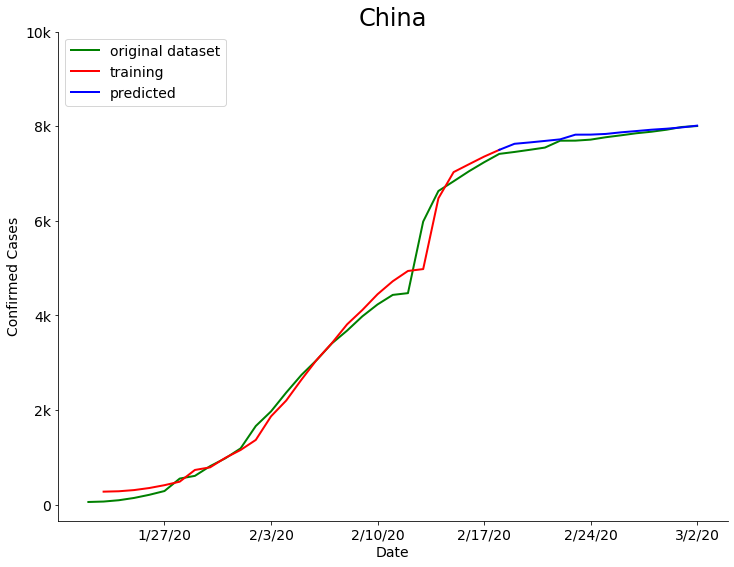

/home/lei/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/lei/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Last Day Value: 80109.4453125
Next Day Value: 80322.078125


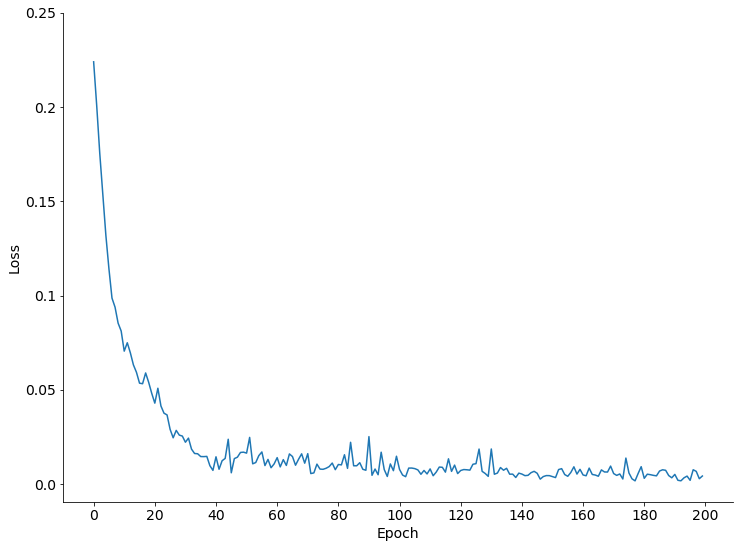

In [11]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(date, dataset, 'g', lw=2, label = 'original dataset')
ax.plot(date, trainPredictPlot, 'r', lw=2, label = 'training')
ax.plot(date, testPredictPlot, 'b', lw=2, label = 'predicted')
plt.title('China', fontsize=24)
plt.xticks(date[::-7], fontsize=14)
plt.yticks(range(0, 100001, 20000), ['0']+[str(x) + "k" for x in range(2, 11, 2)], fontsize=14)
plt.legend(loc = 'upper left', prop={'size':14})
plt.xlabel('Date', fontsize=14)
plt.ylabel('Confirmed Cases', fontsize=14)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.show()

# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print(np.append(last_val, next_val))

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

# Plot training & validation accuracy values
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(range(0, 201, 20), fontsize=14)    
plt.yticks([i/100 for i in range(0, 26, 5)], [str(x/100) for x in range(0, 26, 5)], fontsize=14)
#plt.legend(['Train', 'Test'], loc='upper left')
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.show()